In [53]:
from model_autoencoder import Autoencoder
from dataset import Dataset
import torch
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.metrics import roc_curve, auc, recall_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from config import SAVED_MODEL, ANNOTATED_PATCHES_DIR, METADATA_FILE, WINDOW_METADATA_FILE, PLOT_LOSS_DIR

In [2]:
model = Autoencoder()
model.load_state_dict(torch.load(SAVED_MODEL))

metadata = pd.read_csv(METADATA_FILE)
window_metadata = pd.read_csv(WINDOW_METADATA_FILE)

directories = [dir.path for dir in os.scandir(ANNOTATED_PATCHES_DIR) if dir.is_dir()]

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128), antialias=True),
    transforms.Normalize(mean=[0.5], std=[0.5])])

In [4]:
def red_pixels(img):
    img = img.permute(1, 2, 0).detach().numpy()
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_limit = 340
    upper_limit = 20
    count = ((img[:, :, 0] >= lower_limit) | (img[:, :, 0] <= upper_limit)).sum()

    return count

In [65]:
targets = []
props = []
target_patch = []
val_ppatch = []
prop_pat = []
eps = 15
dirs_patch = []
pred_prova = []

for dir in directories:
    if metadata.loc[metadata["CODI"] == dir.split("/")[-1].split("_")[0], "DENSITAT"].values[0] == "NEGATIVA":
        target = 0
    else:
        target = 1
    files = os.listdir(dir)
    if len(files) == 0:
        continue
    predict_patches = 0
    for file in files:
        if window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == -1:
            target_patch.append(0)
        else:
            target_patch.append(1)
        img = read_image(os.path.join(dir, file))[:-1,:,:]
        img = img.to(torch.float32)
        img = img/255
        img = transform(img)
        model.eval()
        img_processed = model(img, "autoencoder")
        red_pixels_original = red_pixels(img)
        red_pixels_output = red_pixels(img_processed)

        if (red_pixels_original+eps)/(red_pixels_output+eps) > 1.4:
                predict_patches += 1
                val_ppatch.append(1)
        else:
            val_ppatch.append(0)
        prop_pat.append((red_pixels_original+eps)/(red_pixels_output+eps))
        dirs_patch.append(dir.split('/')[-1]+'/'+file)
    prop = predict_patches/len(files)
    if predict_patches > 1:
        pred_prova.append(1)
    else:
        pred_prova.append(0)

    targets.append(target)
    props.append(prop)

<ipython-input-65-c9a78f281839>:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == -1:


In [66]:
final_results2 = pd.DataFrame({"Target": target_patch, "Prop": prop_pat, "Dirs": dirs_patch})

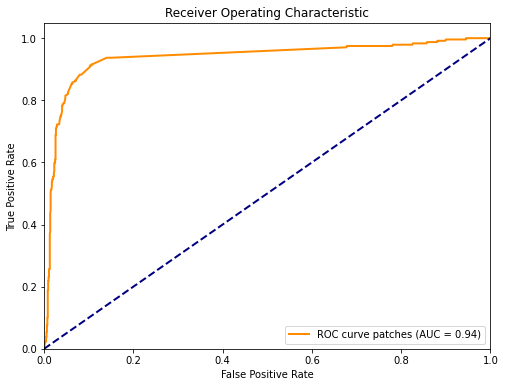

In [67]:
fpr2, tpr2, thresholds2 = roc_curve(final_results2['Target'], final_results2['Prop'])
roc_auc2 = auc(fpr2, tpr2)
plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label=f'ROC curve patches (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig(f"{PLOT_LOSS_DIR}ROCcurve2.png")

In [68]:
J2 = tpr2 - fpr2
best_threshold2 = thresholds2[np.argmax(J2)]
print(best_threshold2)

1.1111111111111112


In [69]:
# Define the target and predicted labels using the best threshold
predicted_labels2 = [0 if prob2 < best_threshold2 else 1 for prob2 in prop_pat]

In [70]:
# Calculate the confusion matrix
confusion_matrix2 = metrics.confusion_matrix(target_patch, predicted_labels2)

# Print the confusion matrix
print("Confusion matrix patches:")
print(confusion_matrix2)

Confusion matrix patches:
[[975 116]
 [ 20 218]]


In [71]:
final_results2['Preds'] = predicted_labels2

In [72]:
final_results2

,Target,Prop,Dirs,Preds
0,0,1.000000,B22-270_0/01134.png,0
1,0,1.000000,B22-270_0/01133.png,0
2,0,1.000000,B22-47_0/01236.png,0
3,0,1.000000,B22-47_0/00285.png,0
4,0,1.133333,B22-47_0/01549.png,1
...,...,...,...,...
1324,0,1.000000,B22-250_0/02948.png,0
1325,0,0.837209,B22-250_0/01404.png,0
1326,0,0.937500,B22-250_0/01765.png,0
1327,0,1.200000,B22-250_0/01121.png,1


In [73]:

final_results = pd.DataFrame({"Target": targets, "Prop": props})

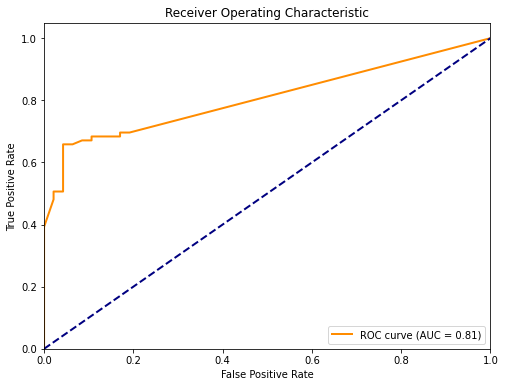

In [74]:
fpr, tpr, thresholds = roc_curve(final_results['Target'], final_results['Prop'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig(f"{PLOT_LOSS_DIR}ROCcurve.png")

In [48]:

J = tpr - fpr
best_threshold = thresholds[np.argmax(J)]
print(best_threshold)

0.25


In [62]:
# Define the target and predicted labels using the best threshold
predicted_labels = [0 if prob < 0.01 else 1 for prob in props]

In [63]:
# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(targets, predicted_labels)

In [56]:
confusion_matrix = metrics.confusion_matrix(targets, predictes)

In [64]:
# Print the confusion matrix
print("Confusion matrix:")
print(confusion_matrix)

Confusion matrix:
[[34 13]
 [18 61]]


In [58]:
recall_score(targets, predicted_labels)

0.7468354430379747